<a href="https://colab.research.google.com/github/carloscotrini/transformers_from_scratch/blob/main/AML_MyDiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import random

SHAPES = ["triangle", "circle"]
PLURALS = [shape + "s" for shape in SHAPES]
ARTICLES = ["a", "one"]
TWO_ARTICLES = ["two"]
CONNECTORS = ["and", "then"]
REVERSE_CONNECTORS = ["after"]
CLASS_TOKEN = "CLS"
MASK_TOKEN = "MASK"
SEP_TOKEN = "SEP"
PAD_TOKEN = "PAD"
EOS_TOKEN = "EOS"
SPECIAL_TOKENS = [CLASS_TOKEN, MASK_TOKEN, SEP_TOKEN, PAD_TOKEN, EOS_TOKEN]
VOCABULARY = SHAPES + PLURALS + ARTICLES + CONNECTORS + REVERSE_CONNECTORS + TWO_ARTICLES + SPECIAL_TOKENS
MAX_LEN_SENTENCE = 16 # Maximum possible length of a sequence

def generate_random_shapes():
  num_shapes = random.randint(1, 4)
  result = []
  for _ in range(num_shapes):
    result.append(random.choice(SHAPES))
  return result

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

def generate_image(word_list, filename, mask_filename):
    # Create a blank 32x32 image
    image_size = 32
    patch_size = 16
    image = Image.new("1", (image_size, image_size), 1)  # '1' for 1-bit pixels, black and white
    mask = Image.new("1", (image_size, image_size), 1)

    for i, word in enumerate(word_list):
        if word not in ["triangle", "circle"]:
            continue

        # Determine the top-left corner of the patch
        x_offset = (i % 2) * patch_size
        y_offset = (i // 2) * patch_size

        # Draw the shape in the corresponding patch
        draw = ImageDraw.Draw(image)
        draw_mask = ImageDraw.Draw(mask)
        if word == "triangle":
            points = [(random.randint(x_offset, x_offset + patch_size), random.randint(y_offset, y_offset + patch_size)) for _ in range(3)]
            draw.polygon(points, fill=0)
            draw_mask.polygon(points, fill=0)
        elif word == "circle":
            radius = random.randint(2, patch_size // 2)
            center_x = random.randint(x_offset + radius, x_offset + patch_size - radius)
            center_y = random.randint(y_offset + radius, y_offset + patch_size - radius)
            draw.ellipse([center_x - radius, center_y - radius, center_x + radius, center_y + radius], fill=0)

    # Save the image to the specified filename
    image.save(filename)
    mask.save(mask_filename)

def plot_image(filename):
    # Open the image
    image = Image.open(filename)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage:
generate_image(["circle", "triangle", "circle"], "output_image.png", "masked_output_image.png")

In [42]:
def generate_data(n_samples):
  examples = []
  for i in range(n_samples):
    shape_list = generate_random_shapes()
    filename = f"f{i}.png"
    mask_filename = f"m{i}.png"
    generate_image(shape_list, filename, mask_filename)
    examples.append({"shape_list": shape_list, "filename": filename, "mask_filename": mask_filename})
  return examples

In [43]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [44]:
class FigureDataset(Dataset):
    def __init__(self, n_samples, image_dir=".", transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.examples = generate_data(n_samples)
        self.image_files = [e["filename"] for e in self.examples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')

        if self.transform:
            image = self.transform(image)

        return image

In [59]:
import math

class MyPositionalEncoding():
    def __init__(self, d_model, T):
        super(MyPositionalEncoding, self).__init__()

        # Create a matrix of shape (max_len, d_model) with all zeros
        self.pe = torch.zeros(T + 1, d_model)

        # Create a column vector of shape (max_len, 1) with values [0, 1, ..., max_len-1]
        position = torch.arange(0, T + 1, dtype=torch.float).unsqueeze(1)

        # Create a row vector of shape (1, d_model // 2) with values [0, 1, ..., d_model//2-1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices and cosine to odd indices
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)

In [125]:
class DiffusionModel():

  def __init__(self, T, model: nn.Module):
    self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
    self.alphas = 1 - self.betas
    self.alphas_bar = torch.cumprod(self.alphas, 0)

    self.T = T
    self.model = model

  def forward_process(self, x0, t):
    """
    :param t: Number of diffusion steps
    """

    t = t - 1 # Because we start indexing at 0

    factors = self.alphas_bar[t].view(self.alphas_bar[t].shape + (1, ) * (len(x0.shape) - 1))
    mu = torch.sqrt(factors) * x0
    std = torch.sqrt(1 - factors)
    epsilon = torch.randn_like(x0)

    return mu + epsilon * std # data ~ N(mu, std)

  def reverse_process(self, xt, t):
    """
    :param t: Number of diffusion steps
    """

    t = t - 1 # Because we start indexing at 0

    z = torch.randn_like(xt)

    std = torch.sqrt(self.betas[t]).view(self.betas[t].shape[0], 1, 1, 1)

    pred_eps = self.model(xt, t)

    alphas = self.alphas[t].view(self.alphas[t].shape[0], 1, 1, 1)
    alphas_bar = self.alphas_bar[t].view(self.alphas_bar[t].shape[0], 1, 1, 1)

    a = (1 / torch.sqrt(alphas))
    b = (xt - (1 - alphas) / torch.sqrt(1 - alphas_bar) * pred_eps)
    c = std * z
    xt_1 = a * b + c

    return xt_1

  def sample(self, batch_size, height, width):
    noise = torch.randn((batch_size, 1, height, width))
    x = noise

    samples = [x]
    for t in range(self.T, 0, -1):

        if not (t == 1):
            x = self.reverse_process(x, torch.tensor([t] * batch_size))

        samples.append(x)

    return samples[::-1]

In [126]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, t_emb_dim,
                 kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.linear = nn.Linear(t_emb_dim, out_channels)
        self.t_emb_dim = t_emb_dim
        self.pe = MyPositionalEncoding(t_emb_dim, T)

    def forward(self, x, t_emb):
        x = self.conv(x)
        t_emb = self.linear(t_emb)
        t_emb = t_emb.view(x.shape[0], x.shape[1], 1, 1)
        x += t_emb
        x = self.norm(x)
        x = self.relu(x)
        return x

class MyUNet(nn.Module):
    def __init__(self, t_emb_dim):
        super(MyUNet, self).__init__()

        self.enc1 = ConvBlock(1, 4, t_emb_dim)
        self.enc2 = ConvBlock(4, 8, t_emb_dim)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.center = ConvBlock(8, 16, t_emb_dim)

        self.up2 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(16, 8, t_emb_dim)
        self.up1 = nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(8, 4, t_emb_dim)

        self.final = nn.Conv2d(4, 1, kernel_size=1)

        self.t_emb_dim = t_emb_dim
        self.pe = MyPositionalEncoding(t_emb_dim, T)

    def forward(self, x, t):
        t_emb = self.pe.pe[t, :]
        enc1 = self.enc1(x, t_emb)
        enc2 = self.enc2(self.pool(enc1), t_emb)

        center = self.center(self.pool(enc2), t_emb)

        dec2 = self.dec2(torch.cat([self.up2(center), enc2], dim=1), t_emb)
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1), t_emb)

        return torch.sigmoid(self.final(dec1))

In [127]:
from tqdm import tqdm
from torch.nn import MSELoss

# Training settings
batch_size = 4
num_epochs = 20
learning_rate = 0.001
t_emb_dim = 4

transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset and split into training and testing sets
dataset = FigureDataset(
    n_samples=200,
    image_dir=".",
    transform=transform
)

train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet = MyUNet(t_emb_dim).to(device)
T = 100
diff_model = DiffusionModel(T=T, model=unet)
criterion = MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  diff_model.model.train()
  for i, images in enumerate(tqdm(train_loader)):
    images = images.to(device)
    t = torch.randint(0, T, (images.size(0),)).to(device)
    x_t = diff_model.forward_process(images, t)
    x_recon = diff_model.reverse_process(x_t, t)
    loss = criterion(x_recon, images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Training complete.")

 30%|███       | 12/40 [00:00<00:00, 55.91it/s]

Epoch [1/20], Step [0/40], Loss: 1.2051


 18%|█▊        | 7/40 [00:00<00:00, 60.26it/s]

Epoch [2/20], Step [0/40], Loss: 1.0327


 18%|█▊        | 7/40 [00:00<00:00, 62.87it/s]

Epoch [3/20], Step [0/40], Loss: 1.1294


 32%|███▎      | 13/40 [00:00<00:00, 60.90it/s]

Epoch [4/20], Step [0/40], Loss: 1.6043


 25%|██▌       | 10/40 [00:00<00:00, 45.81it/s]

Epoch [5/20], Step [0/40], Loss: 0.6247


 25%|██▌       | 10/40 [00:00<00:00, 46.78it/s]

Epoch [6/20], Step [0/40], Loss: 0.7038


  5%|▌         | 2/40 [00:00<00:04,  8.78it/s]

Epoch [7/20], Step [0/40], Loss: 0.5921


  8%|▊         | 3/40 [00:00<00:02, 12.82it/s]

Epoch [8/20], Step [0/40], Loss: 0.6892


  5%|▌         | 2/40 [00:00<00:01, 19.19it/s]

Epoch [9/20], Step [0/40], Loss: 0.4382


 35%|███▌      | 14/40 [00:00<00:00, 64.36it/s]

Epoch [10/20], Step [0/40], Loss: 0.9136


 35%|███▌      | 14/40 [00:00<00:00, 67.20it/s]

Epoch [11/20], Step [0/40], Loss: 1.7556


 18%|█▊        | 7/40 [00:00<00:00, 68.21it/s]

Epoch [12/20], Step [0/40], Loss: 0.9067


 18%|█▊        | 7/40 [00:00<00:00, 66.24it/s]

Epoch [13/20], Step [0/40], Loss: 1.5183


 35%|███▌      | 14/40 [00:00<00:00, 65.29it/s]

Epoch [14/20], Step [0/40], Loss: 1.7246


 35%|███▌      | 14/40 [00:00<00:00, 65.03it/s]

Epoch [15/20], Step [0/40], Loss: 0.2186


 35%|███▌      | 14/40 [00:00<00:00, 64.78it/s]

Epoch [16/20], Step [0/40], Loss: 0.4571


 35%|███▌      | 14/40 [00:00<00:00, 67.49it/s]

Epoch [17/20], Step [0/40], Loss: 0.6289


 18%|█▊        | 7/40 [00:00<00:00, 62.10it/s]

Epoch [18/20], Step [0/40], Loss: 0.4175


 35%|███▌      | 14/40 [00:00<00:00, 66.59it/s]

Epoch [19/20], Step [0/40], Loss: 0.4208


 22%|██▎       | 9/40 [00:00<00:00, 42.92it/s]

Epoch [20/20], Step [0/40], Loss: 0.0255


100%|██████████| 40/40 [00:00<00:00, 45.68it/s]

Training complete.


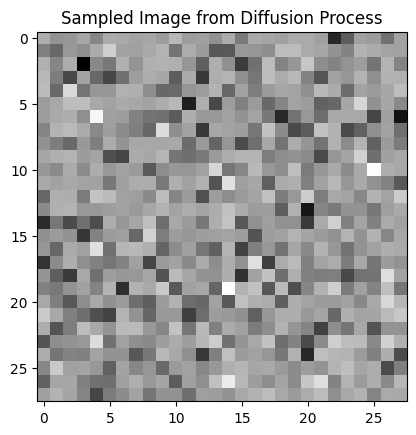

In [128]:
import torch
import matplotlib.pyplot as plt


# Sampling an image
sampled_image = diff_model.sample(batch_size=4, height=28, width=28)[0][0]
sampled_image = sampled_image.view(28, 28).cpu().detach().numpy()

# Display the sampled image
plt.imshow(sampled_image, cmap='gray')
plt.title('Sampled Image from Diffusion Process')
plt.show()
